# Robust Meta Learning

This notebook summarizes the experiments of RoML (Robust Meta Learning) in the toy sine benchmark.
The last section of the notebook (**Multi-seed test**) corresponds to the experiments reported in the paper.

___________________

#### Experimental code beyond the scope of the paper
In addition to the algorithms presented in the paper (*MAML*, *CVaR-ML* and *RoML*), **an experimental version of RoML is presented below under the name *CVaR-RoML***.
This version did not seem to provide added value and is not presented in the paper.
In some sense, it combines CVaR-ML and RoML: difficult tasks are over-sampled like in RoML, so data-efficiency is better than CVaR-ML. Yet, the $\alpha$-quantile return is estimated, and whichever tasks above it are excluded from the gradient calculation, like in CVaR-ML, so not the whole batch is used as in RoML.

In [1]:
cd ..

d:\code\python\others\Anonymous_repos\RAML


In [2]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
import MAML, BaseLearner
import Sine
import utils

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.output_result { max-width:90% !important; }</style>"))
np.set_printoptions(precision=4)
np.set_printoptions(linewidth=150)
np.set_printoptions(suppress=True)
torch.set_printoptions(linewidth=150)

## Single-seed demonstration

In [3]:
common_args = dict(
    model_constructor=Sine.get_sine_model,
    ranges=((0.1,5), (0,2*np.pi), (0.3,3))  # notice the frequency in (0.3,3)
)

# cvar_obj = optimizer target; alpha = sampler target
args = dict(
    MAML=dict(),
    RoML=dict(alpha=0.05),
    CVaR_ML=dict(cvar_obj=0.05),
    CVaR_RoML=dict(cvar_obj=0.05, alpha=0.05),
)

constructors = {k:(Sine.SineRAML if 'RoML' in k else Sine.SineMAML) for k in args}

In [4]:
%%time
E = MAML.Experiment(constructors, args, common_args)

CPU times: user 571 µs, sys: 340 µs, total: 911 µs
Wall time: 891 µs


In [5]:
%%time
E.train()


Training MAML...
[0000/10000] valid_loss=3.64	(0 [s])
[1000/10000] loss=3.60	(26 [s])
[2000/10000] valid_loss=3.01	(51 [s])
[2000/10000] loss=3.30	(51 [s])
[3000/10000] loss=3.23	(76 [s])
[4000/10000] valid_loss=2.95	(102 [s])
[4000/10000] loss=3.25	(102 [s])
[5000/10000] loss=3.22	(127 [s])
[6000/10000] valid_loss=2.89	(152 [s])
[6000/10000] loss=3.21	(152 [s])
[7000/10000] loss=3.19	(177 [s])
[8000/10000] valid_loss=2.81	(202 [s])
[8000/10000] loss=3.19	(202 [s])
[9000/10000] loss=3.18	(227 [s])
[10000/10000] valid_loss=2.85	(252 [s])
Best model at iteration 8000/10000, best loss = 2.81.

Training RoML...
[0000/10000] valid_loss=13.19	(0 [s])
[1000/10000] loss=10.24	(33 [s])
[2000/10000] valid_loss=12.63	(66 [s])
[2000/10000] loss=9.91	(66 [s])
[3000/10000] loss=9.64	(99 [s])
[4000/10000] valid_loss=12.68	(132 [s])
[4000/10000] loss=9.26	(132 [s])
[5000/10000] loss=9.27	(166 [s])
[6000/10000] valid_loss=11.64	(200 [s])
[6000/10000] loss=8.99	(200 [s])
[7000/10000] loss=8.72	(233 [s]

In [6]:
%%time
E.test()

Testing MAML... done (31 [s])
Testing RoML... done (31 [s])
Testing CVaR_ML... done (31 [s])
Testing CVaR_RoML... done (31 [s])
CPU times: user 2min 3s, sys: 4.02 ms, total: 2min 3s
Wall time: 2min 3s


This time, risk-aversion seems to affect the CVaR a little, even though the CEM still mostly focuses on amplitude (higher frequency is also somewhat prefered):

RoML
CVaR_RoML


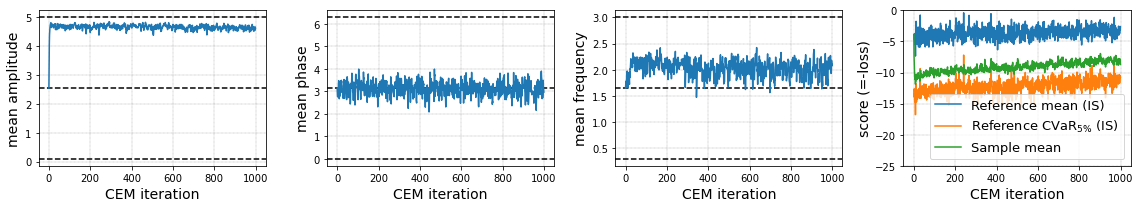

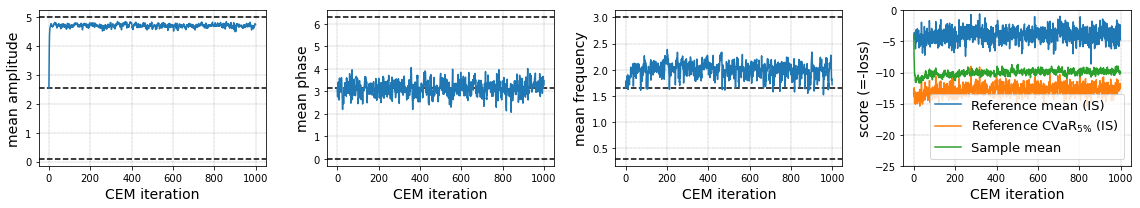

In [7]:
for k,m in E.mamls.items():
    if 'RoML' in k:
        print(k)
        m.ce_summary(utils.Axes(4, 4, (4,3), fontsize=14));
        plt.savefig(f'Sine/outputs/CEM_{k}.png', bbox_inches='tight', dpi=300);

CPU times: user 4.27 s, sys: 348 ms, total: 4.62 s
Wall time: 4.29 s


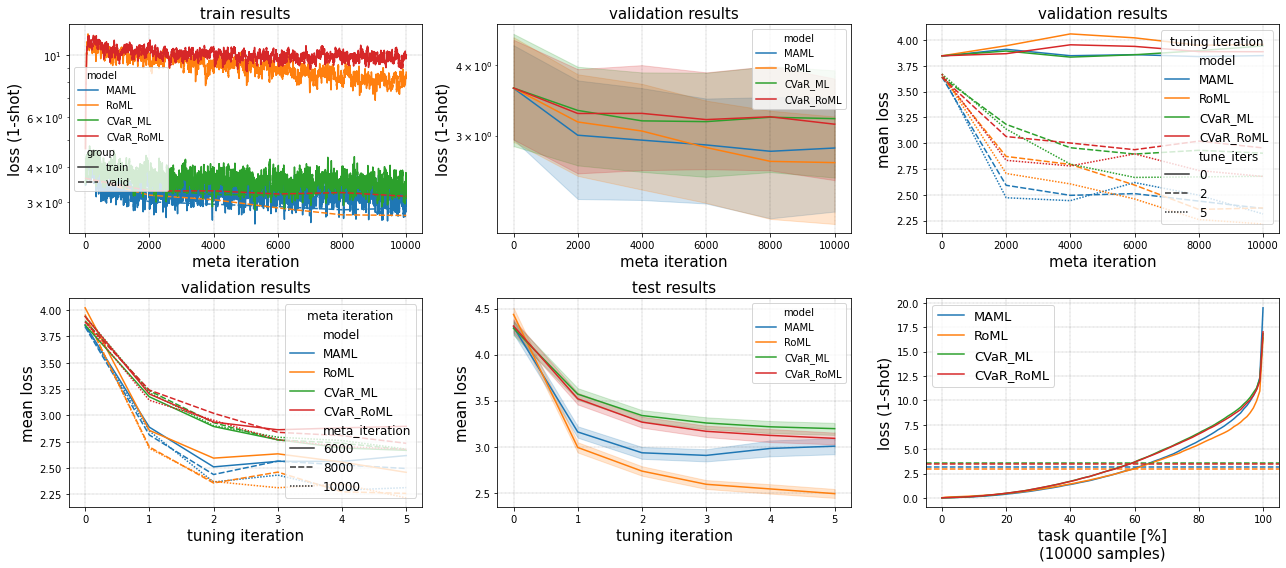

In [8]:
%%time
axs = E.analyze_all()

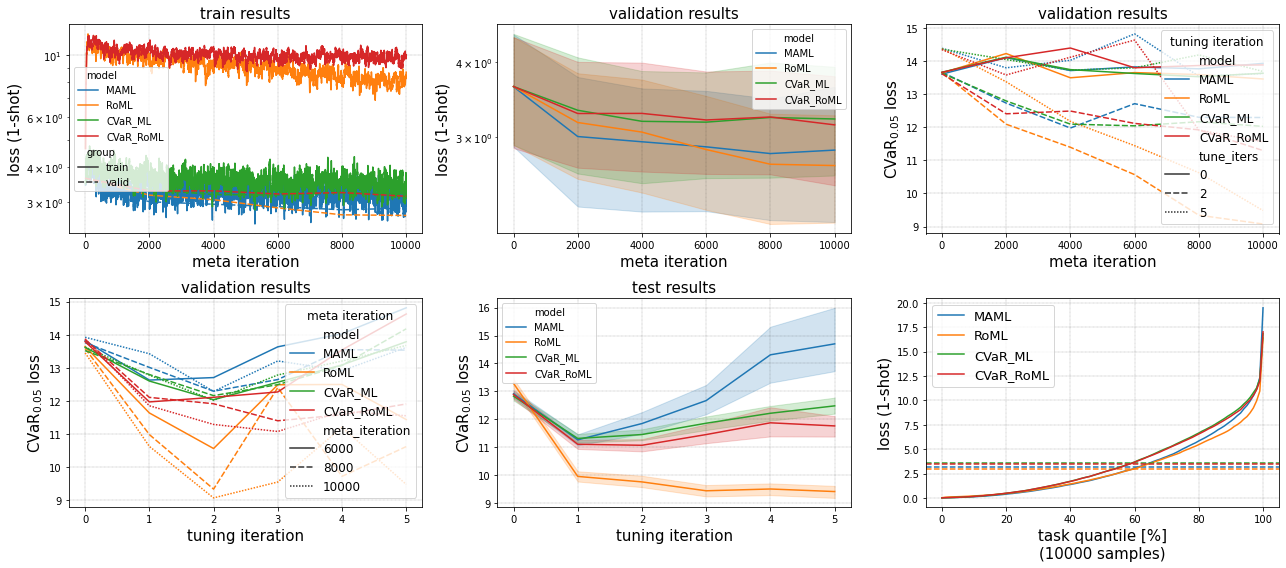

In [9]:
axs = E.analyze_all(est='cvar05')

In [10]:
# %%time
# E.analyze_each()

### Sample sizes

MAML and RoML exploit the whole data; CVaR-ML only exploits 5\% of the data; CVaR-RoML generates 40\% of its samples beneath the 5\% quantile of the loss, thus exploits 40\% of the data.

In [15]:
ss = pd.DataFrame()
for k,maml in E.mamls.items():
    s = pd.DataFrame(dict(
        model = k,
        iteration = np.arange(len(maml.cvar_threshs)),
        thresh = utils.smooth(maml.cvar_threshs, 100),
        sample_size = 100*utils.smooth(maml.sample_size, 100),
        eff_sample_size = 100*utils.smooth(maml.eff_sample_size, 100),
    ))
    ss = pd.concat((ss, s))
ss.reset_index(drop=True, inplace=True)

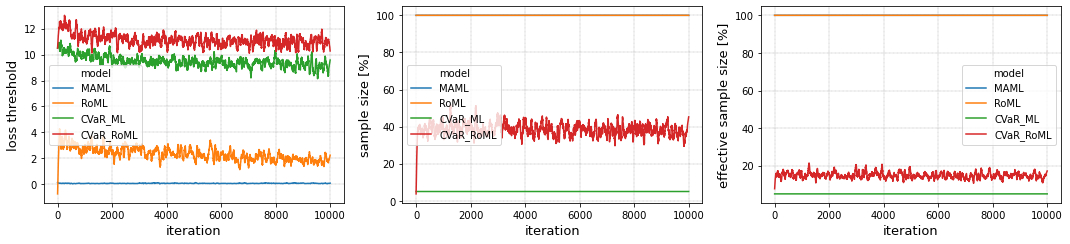

In [16]:
axs = utils.Axes(3, 3)
a = 0

sns.lineplot(data=ss, hue='model', x='iteration', y='thresh', ci=None, ax=axs[a])
axs.labs(a, 'iteration', 'loss threshold')
a += 1
    
sns.lineplot(data=ss, hue='model', x='iteration', y='sample_size', ci=None, ax=axs[a])
axs.labs(a, 'iteration', 'sample size [%]')
a += 1
    
sns.lineplot(data=ss, hue='model', x='iteration', y='eff_sample_size', ci=None, ax=axs[a])
axs.labs(a, 'iteration', 'effective sample size [%]')
a += 1

plt.tight_layout()

# Multi-seed test

In [17]:
common_args = dict(
    n_seeds=30,
    model_constructor=Sine.get_sine_model,
    ranges=((0.1,5), (0,2*np.pi), (0.3,3))
)

# cvar_obj = optimizer target; alpha = sampler target
args = {
    'MAML':dict(constructor=Sine.SineMAML),
    'RoML':dict(constructor=Sine.SineRAML, alpha=0.05),
    'CVaR_ML':dict(constructor=Sine.SineMAML, cvar_obj=0.05),
    'CVaR_RoML':dict(constructor=Sine.SineRAML, cvar_obj=0.05, alpha=0.05),
}

In [18]:
%%time
ME = MAML.SeedsExperiment(args, common_args)
ME.train()
ME.test()


Training MAML...

Training seed 0...
[0000/10000] valid_loss=3.64	(0 [s])
[1000/10000] loss=3.60	(25 [s])
[2000/10000] valid_loss=3.01	(50 [s])
[2000/10000] loss=3.30	(50 [s])
[3000/10000] loss=3.23	(74 [s])
[4000/10000] valid_loss=2.95	(99 [s])
[4000/10000] loss=3.25	(99 [s])
[5000/10000] loss=3.22	(124 [s])
[6000/10000] valid_loss=2.89	(149 [s])
[6000/10000] loss=3.21	(149 [s])
[7000/10000] loss=3.19	(174 [s])
[8000/10000] valid_loss=2.81	(199 [s])
[8000/10000] loss=3.19	(199 [s])
[9000/10000] loss=3.18	(224 [s])
[10000/10000] valid_loss=2.85	(249 [s])
Best model at iteration 8000/10000, best loss = 2.81.

Training seed 1...
[0000/10000] valid_loss=3.66	(0 [s])
[1000/10000] loss=3.60	(25 [s])
[2000/10000] valid_loss=2.96	(50 [s])
[2000/10000] loss=3.28	(50 [s])
[3000/10000] loss=3.23	(74 [s])
[4000/10000] valid_loss=2.90	(100 [s])
[4000/10000] loss=3.18	(100 [s])
[5000/10000] loss=3.17	(125 [s])
[6000/10000] valid_loss=2.87	(150 [s])
[6000/10000] loss=3.07	(150 [s])
[7000/10000] los

[8000/10000] valid_loss=2.43	(198 [s])
[8000/10000] loss=2.78	(198 [s])
[9000/10000] loss=2.76	(222 [s])
[10000/10000] valid_loss=2.43	(247 [s])
Best model at iteration 8000/10000, best loss = 2.43.

Training seed 14...
[0000/10000] valid_loss=3.71	(0 [s])
[1000/10000] loss=3.64	(25 [s])
[2000/10000] valid_loss=2.99	(50 [s])
[2000/10000] loss=3.41	(50 [s])
[3000/10000] loss=3.31	(74 [s])
[4000/10000] valid_loss=3.03	(99 [s])
[4000/10000] loss=3.30	(99 [s])
[5000/10000] loss=3.30	(123 [s])
[6000/10000] valid_loss=2.95	(148 [s])
[6000/10000] loss=3.26	(148 [s])
[7000/10000] loss=3.22	(173 [s])
[8000/10000] valid_loss=2.74	(197 [s])
[8000/10000] loss=3.21	(197 [s])
[9000/10000] loss=3.15	(222 [s])
[10000/10000] valid_loss=2.67	(247 [s])
Best model at iteration 10000/10000, best loss = 2.67.

Training seed 15...
[0000/10000] valid_loss=3.68	(0 [s])
[1000/10000] loss=3.65	(25 [s])
[2000/10000] valid_loss=3.05	(50 [s])
[2000/10000] loss=3.38	(50 [s])
[3000/10000] loss=3.33	(74 [s])
[4000/100

[5000/10000] loss=3.28	(123 [s])
[6000/10000] valid_loss=3.15	(147 [s])
[6000/10000] loss=3.29	(147 [s])
[7000/10000] loss=3.28	(172 [s])
[8000/10000] valid_loss=3.08	(196 [s])
[8000/10000] loss=3.28	(196 [s])
[9000/10000] loss=3.33	(220 [s])
[10000/10000] valid_loss=3.07	(245 [s])
Best model at iteration 2000/10000, best loss = 2.91.

Training seed 28...
[0000/10000] valid_loss=3.73	(0 [s])
[1000/10000] loss=3.69	(25 [s])
[2000/10000] valid_loss=2.97	(49 [s])
[2000/10000] loss=3.33	(49 [s])
[3000/10000] loss=3.28	(73 [s])
[4000/10000] valid_loss=2.95	(98 [s])
[4000/10000] loss=3.20	(98 [s])
[5000/10000] loss=3.22	(122 [s])
[6000/10000] valid_loss=2.87	(146 [s])
[6000/10000] loss=3.21	(146 [s])
[7000/10000] loss=3.15	(170 [s])
[8000/10000] valid_loss=2.78	(195 [s])
[8000/10000] loss=3.14	(195 [s])
[9000/10000] loss=3.02	(219 [s])
[10000/10000] valid_loss=2.51	(243 [s])
Best model at iteration 10000/10000, best loss = 2.51.

Training seed 29...
[0000/10000] valid_loss=3.65	(0 [s])
[1000

[0000/10000] valid_loss=13.92	(0 [s])
[1000/10000] loss=10.50	(34 [s])
[2000/10000] valid_loss=13.02	(67 [s])
[2000/10000] loss=9.84	(67 [s])
[3000/10000] loss=9.52	(100 [s])
[4000/10000] valid_loss=12.22	(134 [s])
[4000/10000] loss=9.50	(134 [s])
[5000/10000] loss=9.38	(168 [s])
[6000/10000] valid_loss=11.82	(202 [s])
[6000/10000] loss=9.44	(202 [s])
[7000/10000] loss=9.33	(236 [s])
[8000/10000] valid_loss=12.30	(270 [s])
[8000/10000] loss=9.36	(270 [s])
[9000/10000] loss=9.40	(304 [s])
[10000/10000] valid_loss=13.85	(338 [s])
Best model at iteration 6000/10000, best loss = 11.82.

Training seed 12...
[0000/10000] valid_loss=13.23	(0 [s])
[1000/10000] loss=10.47	(33 [s])
[2000/10000] valid_loss=13.19	(67 [s])
[2000/10000] loss=9.93	(67 [s])
[3000/10000] loss=9.81	(100 [s])
[4000/10000] valid_loss=13.80	(134 [s])
[4000/10000] loss=9.87	(134 [s])
[5000/10000] loss=9.60	(167 [s])
[6000/10000] valid_loss=12.64	(201 [s])
[6000/10000] loss=9.75	(201 [s])
[7000/10000] loss=9.73	(234 [s])
[80

[6000/10000] valid_loss=12.28	(203 [s])
[6000/10000] loss=9.88	(203 [s])
[7000/10000] loss=9.86	(237 [s])
[8000/10000] valid_loss=12.01	(272 [s])
[8000/10000] loss=9.66	(272 [s])
[9000/10000] loss=9.37	(305 [s])
[10000/10000] valid_loss=12.63	(339 [s])
Best model at iteration 8000/10000, best loss = 12.01.

Training seed 25...
[0000/10000] valid_loss=13.33	(0 [s])
[1000/10000] loss=10.25	(34 [s])
[2000/10000] valid_loss=13.33	(68 [s])
[2000/10000] loss=9.94	(68 [s])
[3000/10000] loss=9.69	(101 [s])
[4000/10000] valid_loss=12.39	(136 [s])
[4000/10000] loss=9.73	(136 [s])
[5000/10000] loss=9.82	(170 [s])
[6000/10000] valid_loss=13.12	(204 [s])
[6000/10000] loss=9.91	(204 [s])
[7000/10000] loss=9.61	(237 [s])
[8000/10000] valid_loss=11.70	(271 [s])
[8000/10000] loss=9.48	(271 [s])
[9000/10000] loss=9.67	(305 [s])
[10000/10000] valid_loss=12.89	(339 [s])
Best model at iteration 8000/10000, best loss = 11.70.

Training seed 26...
[0000/10000] valid_loss=13.54	(0 [s])
[1000/10000] loss=10.30

[0000/10000] valid_loss=13.65	(0 [s])
[1000/10000] loss=4.00	(17 [s])
[2000/10000] valid_loss=12.53	(33 [s])
[2000/10000] loss=3.80	(33 [s])
[3000/10000] loss=3.74	(50 [s])
[4000/10000] valid_loss=12.11	(66 [s])
[4000/10000] loss=3.58	(66 [s])
[5000/10000] loss=3.64	(82 [s])
[6000/10000] valid_loss=12.36	(99 [s])
[6000/10000] loss=3.57	(99 [s])
[7000/10000] loss=3.57	(115 [s])
[8000/10000] valid_loss=12.79	(131 [s])
[8000/10000] loss=3.54	(131 [s])
[9000/10000] loss=3.50	(148 [s])
[10000/10000] valid_loss=12.61	(164 [s])
Best model at iteration 4000/10000, best loss = 12.11.

Training seed 9...
[0000/10000] valid_loss=14.95	(0 [s])
[1000/10000] loss=4.05	(16 [s])
[2000/10000] valid_loss=12.44	(33 [s])
[2000/10000] loss=3.88	(33 [s])
[3000/10000] loss=3.78	(50 [s])
[4000/10000] valid_loss=12.47	(66 [s])
[4000/10000] loss=3.70	(66 [s])
[5000/10000] loss=3.65	(83 [s])
[6000/10000] valid_loss=12.56	(100 [s])
[6000/10000] loss=3.67	(100 [s])
[7000/10000] loss=3.66	(116 [s])
[8000/10000] val

[7000/10000] loss=3.57	(115 [s])
[8000/10000] valid_loss=12.56	(132 [s])
[8000/10000] loss=3.57	(132 [s])
[9000/10000] loss=3.55	(148 [s])
[10000/10000] valid_loss=12.49	(164 [s])
Best model at iteration 4000/10000, best loss = 12.20.

Training seed 22...
[0000/10000] valid_loss=13.57	(0 [s])
[1000/10000] loss=3.99	(17 [s])
[2000/10000] valid_loss=12.39	(33 [s])
[2000/10000] loss=3.75	(33 [s])
[3000/10000] loss=3.64	(49 [s])
[4000/10000] valid_loss=12.43	(66 [s])
[4000/10000] loss=3.63	(66 [s])
[5000/10000] loss=3.53	(82 [s])
[6000/10000] valid_loss=12.63	(99 [s])
[6000/10000] loss=3.54	(99 [s])
[7000/10000] loss=3.57	(115 [s])
[8000/10000] valid_loss=12.40	(131 [s])
[8000/10000] loss=3.50	(131 [s])
[9000/10000] loss=3.53	(148 [s])
[10000/10000] valid_loss=12.67	(164 [s])
Best model at iteration 2000/10000, best loss = 12.39.

Training seed 23...
[0000/10000] valid_loss=13.53	(0 [s])
[1000/10000] loss=3.99	(16 [s])
[2000/10000] valid_loss=12.56	(33 [s])
[2000/10000] loss=3.77	(33 [s])


[1000/10000] loss=10.76	(29 [s])
[2000/10000] valid_loss=12.35	(57 [s])
[2000/10000] loss=10.42	(57 [s])
[3000/10000] loss=10.21	(85 [s])
[4000/10000] valid_loss=12.64	(114 [s])
[4000/10000] loss=9.98	(114 [s])
[5000/10000] loss=10.08	(144 [s])
[6000/10000] valid_loss=12.46	(173 [s])
[6000/10000] loss=10.05	(173 [s])
[7000/10000] loss=10.01	(201 [s])
[8000/10000] valid_loss=12.78	(229 [s])
[8000/10000] loss=10.01	(229 [s])
[9000/10000] loss=9.93	(257 [s])
[10000/10000] valid_loss=12.55	(285 [s])
Best model at iteration 2000/10000, best loss = 12.35.

Training seed 6...
[0000/10000] valid_loss=13.91	(0 [s])
[1000/10000] loss=10.78	(28 [s])
[2000/10000] valid_loss=12.41	(57 [s])
[2000/10000] loss=10.62	(57 [s])
[3000/10000] loss=10.26	(85 [s])
[4000/10000] valid_loss=12.62	(114 [s])
[4000/10000] loss=10.05	(114 [s])
[5000/10000] loss=9.88	(142 [s])
[6000/10000] valid_loss=12.52	(171 [s])
[6000/10000] loss=9.93	(171 [s])
[7000/10000] loss=9.78	(199 [s])
[8000/10000] valid_loss=12.63	(227 

[6000/10000] valid_loss=12.10	(172 [s])
[6000/10000] loss=9.90	(172 [s])
[7000/10000] loss=9.84	(200 [s])
[8000/10000] valid_loss=12.49	(229 [s])
[8000/10000] loss=9.83	(229 [s])
[9000/10000] loss=9.83	(257 [s])
[10000/10000] valid_loss=12.34	(285 [s])
Best model at iteration 6000/10000, best loss = 12.10.

Training seed 19...
[0000/10000] valid_loss=13.76	(0 [s])
[1000/10000] loss=10.80	(29 [s])
[2000/10000] valid_loss=12.43	(58 [s])
[2000/10000] loss=10.66	(58 [s])
[3000/10000] loss=10.27	(86 [s])
[4000/10000] valid_loss=12.30	(115 [s])
[4000/10000] loss=10.12	(115 [s])
[5000/10000] loss=10.00	(143 [s])
[6000/10000] valid_loss=12.38	(172 [s])
[6000/10000] loss=9.80	(172 [s])
[7000/10000] loss=9.86	(200 [s])
[8000/10000] valid_loss=12.40	(229 [s])
[8000/10000] loss=9.77	(229 [s])
[9000/10000] loss=9.84	(257 [s])
[10000/10000] valid_loss=12.11	(286 [s])
Best model at iteration 10000/10000, best loss = 12.11.

Training seed 20...
[0000/10000] valid_loss=13.36	(0 [s])
[1000/10000] loss=1

Testing CVaR_ML...
Testing seed 0...
Testing seed 1...
Testing seed 2...
Testing seed 3...
Testing seed 4...
Testing seed 5...
Testing seed 6...
Testing seed 7...
Testing seed 8...
Testing seed 9...
Testing seed 10...
Testing seed 11...
Testing seed 12...
Testing seed 13...
Testing seed 14...
Testing seed 15...
Testing seed 16...
Testing seed 17...
Testing seed 18...
Testing seed 19...
Testing seed 20...
Testing seed 21...
Testing seed 22...
Testing seed 23...
Testing seed 24...
Testing seed 25...
Testing seed 26...
Testing seed 27...
Testing seed 28...
Testing seed 29...
Testing CVaR_RoML...
Testing seed 0...
Testing seed 1...
Testing seed 2...
Testing seed 3...
Testing seed 4...
Testing seed 5...
Testing seed 6...
Testing seed 7...
Testing seed 8...
Testing seed 9...
Testing seed 10...
Testing seed 11...
Testing seed 12...
Testing seed 13...
Testing seed 14...
Testing seed 15...
Testing seed 16...
Testing seed 17...
Testing seed 18...
Testing seed 19...
Testing seed 20...
Testing see

In [19]:
ME.test();

Testing MAML...
Testing seed 0...
Testing seed 1...
Testing seed 2...
Testing seed 3...
Testing seed 4...
Testing seed 5...
Testing seed 6...
Testing seed 7...
Testing seed 8...
Testing seed 9...
Testing seed 10...
Testing seed 11...
Testing seed 12...
Testing seed 13...
Testing seed 14...
Testing seed 15...
Testing seed 16...
Testing seed 17...
Testing seed 18...
Testing seed 19...
Testing seed 20...
Testing seed 21...
Testing seed 22...
Testing seed 23...
Testing seed 24...
Testing seed 25...
Testing seed 26...
Testing seed 27...
Testing seed 28...
Testing seed 29...
Testing RoML...
Testing seed 0...
Testing seed 1...
Testing seed 2...
Testing seed 3...
Testing seed 4...
Testing seed 5...
Testing seed 6...
Testing seed 7...
Testing seed 8...
Testing seed 9...
Testing seed 10...
Testing seed 11...
Testing seed 12...
Testing seed 13...
Testing seed 14...
Testing seed 15...
Testing seed 16...
Testing seed 17...
Testing seed 18...
Testing seed 19...
Testing seed 20...
Testing seed 21...


### Mean

CPU times: user 18min 13s, sys: 7.63 s, total: 18min 20s
Wall time: 18min 15s


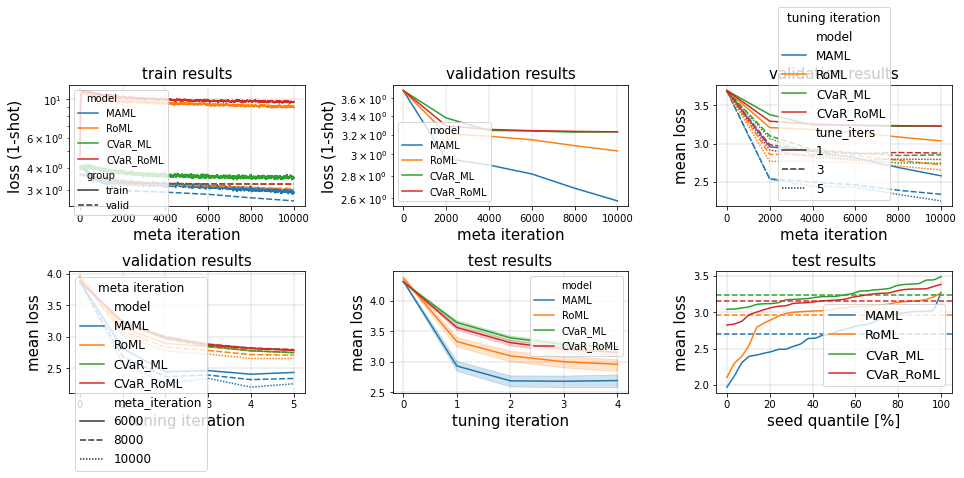

In [20]:
%%time
axs, res_mean = ME.analyze(max_test_iters=4, axsize=(4.5,3), recalculate=True)
plt.savefig(f'Sine/outputs/summary_mean_all.png', bbox_inches='tight', dpi=300);

CPU times: user 3.37 s, sys: 372 ms, total: 3.74 s
Wall time: 3.43 s


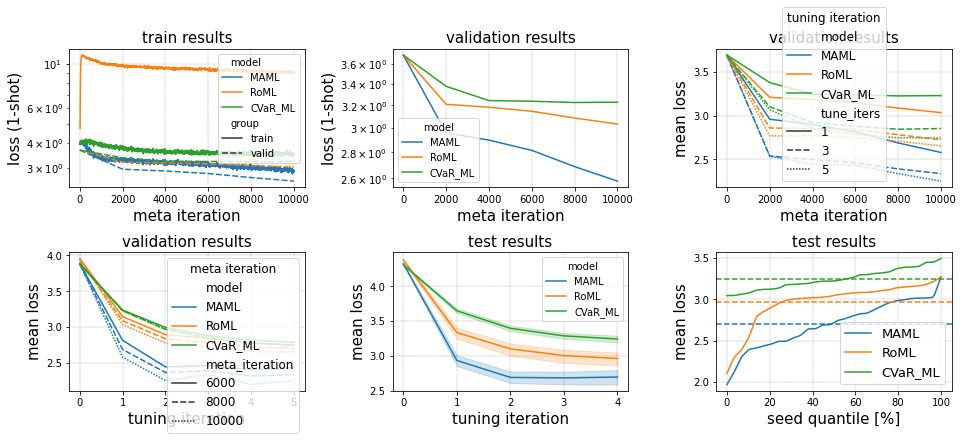

In [38]:
%%time
axs, res_mean = ME.analyze([m for m in E.mamls.keys() if m!='CVaR_RoML'], max_test_iters=4, axsize=(4.5,3), recalculate=False)
plt.savefig(f'Sine/outputs/summary_mean.png', bbox_inches='tight', dpi=300);

### CVaR

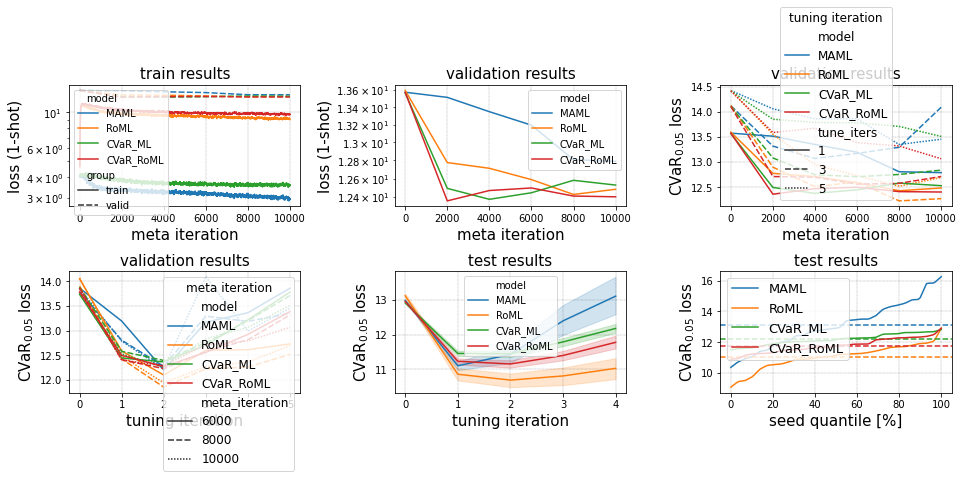

In [22]:
axs, res_cvar = ME.analyze(max_test_iters=4, axsize=(4.5,3), estimator='cvar05', recalculate=True)
plt.savefig(f'Sine/outputs/summary_cvar05_all.png', bbox_inches='tight', dpi=300);

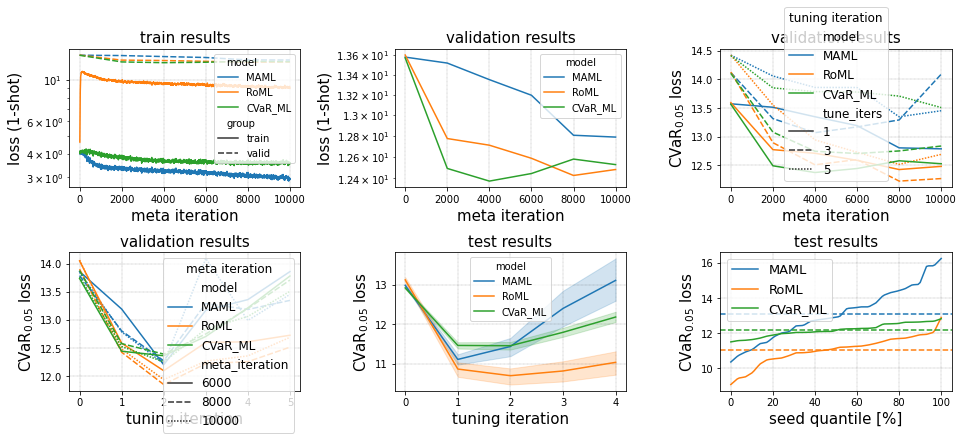

In [39]:
axs, res_cvar = ME.analyze([m for m in E.mamls.keys() if m!='CVaR_RoML'], max_test_iters=4, axsize=(4.5,3), estimator='cvar05', recalculate=False)
plt.savefig(f'Sine/outputs/summary_cvar05.png', bbox_inches='tight', dpi=300);

In [40]:
(train_r, valid_r, test_r), loss_lab = ME.mamls['RoML'].summarize_stats_per_seed(250, 'cvar05')
print('RoML - Var between seeds:', test_r.groupby('seed').apply(lambda d: d.loss.mean()).var())
print('RoML - Var within seeds:', test_r.groupby('seed').apply(lambda d: d.loss.var()).mean())

RoML - Var between seeds: 0.34109633082169044
RoML - Var within seeds: 0.9934017278275517
